#### Decomposition 

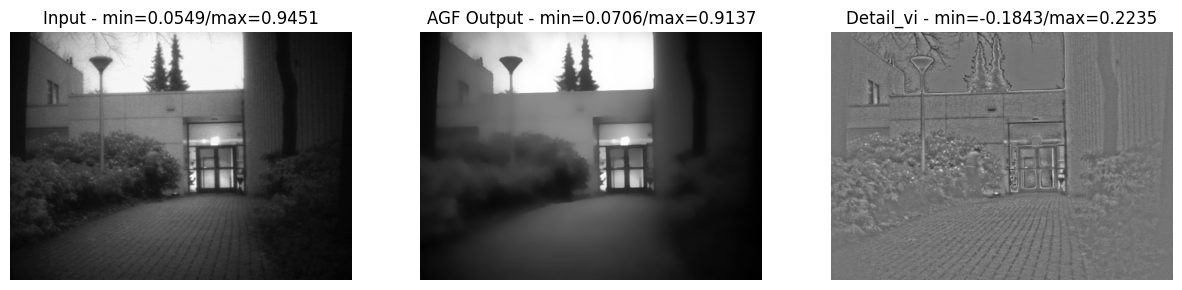

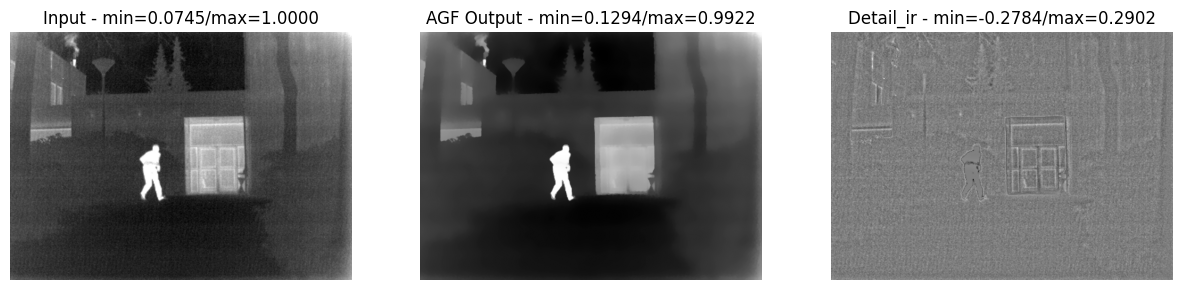

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition

# Decompose the visible image
img_vi = cv2.imread(".\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img_vi = img_vi.astype(np.float32) / 255.0

base_vi, detail_vi = agf_decomposition(
    img_vi,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_vi.min():.4f}/max={img_vi.max():.4f}"); plt.imshow(img_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_vi - min={detail_vi.min():.4f}/max={detail_vi.max():.4f}"); plt.imshow(detail_vi, cmap="gray"); plt.axis("off")
plt.show()

# Decompose the infrared image
img_ir = cv2.imread(".\\data\\TNO\\ir\\17.png", cv2.IMREAD_GRAYSCALE)
img_ir = img_ir.astype(np.float32) / 255.0  

base_ir, detail_ir = agf_decomposition(
    img_ir,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_ir.min():.4f}/max={img_ir.max():.4f}"); plt.imshow(img_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_ir - min={detail_ir.min():.4f}/max={detail_ir.max():.4f}"); plt.imshow(detail_ir, cmap="gray"); plt.axis("off")
plt.show()

In [2]:
restruct_vi = base_vi + detail_vi
restruct_ir = base_ir + detail_ir

# Tính PSNR giữa ảnh gốc và ảnh tái cấu trúc
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

psnr_vi = psnr(img_vi, restruct_vi)
psnr_ir = psnr(img_ir, restruct_ir)
print(f"PSNR between original and reconstructed visible image: {psnr_vi:.2f} dB")
print(f"PSNR between original and reconstructed infrared image: {psnr_ir:.2f} dB")

PSNR between original and reconstructed visible image: inf dB
PSNR between original and reconstructed infrared image: inf dB


#### Detail Fusion

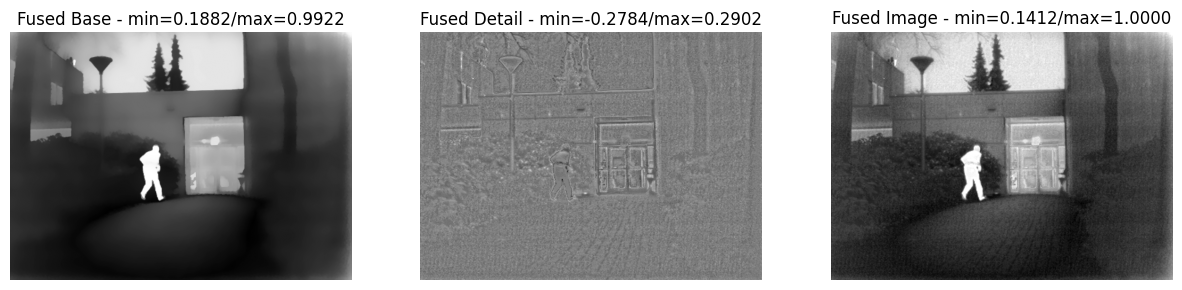

In [3]:
from detail_fusion.MVA_WLE import fuse_detail_dynamic_WLE_im2col_var_optimizer

base_fused = np.maximum(base_vi, base_ir)
detail_fulsed = fuse_detail_dynamic_WLE_im2col_var_optimizer(detail_ir, detail_vi)
fused = np.clip(base_fused + detail_fulsed, 0, 1)

cv2.imwrite(".\\data\\output\\AGF_fusion_base.png", (fused * 255).astype(np.uint8))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title(f"Fused Base - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Fused Detail - min={detail_fulsed.min():.4f}/max={detail_fulsed.max():.4f}"); plt.imshow(detail_fulsed, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Fused Image - min={fused.min():.4f}/max={fused.max():.4f}"); plt.imshow(fused, cmap="gray"); plt.axis("off")
plt.show()

In [4]:
import pandas as pd
from metric.eval_one_image import evaluation_one

ir_image = ".\\data\\TNO\\ir\\17.png"
vi_image = ".\\data\\TNO\\vi\\17.png"
fused_image = ".\\data\\output\\AGF_fusion_base.png"

EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = evaluation_one(ir_image, vi_image, fused_image)

# Tạo bảng kết quả
data = {
    "Metric": [
        "EN", "MI", "SF", "AG", "SD", "MLI", "CC", "SCD",
        "VIF", "MSE", "PSNR", "Qabf", "Nabf", "SSIM", "MS_SSIM"
    ],
    "Value": [
        EN, MI, SF, AG, SD, MLI, CC, SCD,
        VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM
    ]
}

df = pd.DataFrame(data)

# Làm tròn cho đẹp (tuỳ chọn)
df["Value"] = df["Value"].round(6)

# Hiển thị bảng
print(df)


torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
     Metric       Value
0        EN    7.201743
1        MI    4.979669
2        SF    8.959516
3        AG    3.689980
4        SD   51.201192
5       MLI  110.930321
6        CC    0.551340
7       SCD    1.678212
8       VIF    0.753117
9       MSE    0.045876
10     PSNR   61.514984
11     Qabf    0.589758
12     Nabf    0.015815
13     SSIM    0.466394
14  MS_SSIM    0.472515


#### Base Fusion

In [4]:
import torch
import cv2
import numpy as np
from base_fusion.loss import fusion_loss_vif

def load_gray_image(path, device):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot load image: {path}")

    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return img.to(device)


def compute_fusion_loss(image1_path, image2_path, image_fused_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load images
    image_A = load_gray_image(image1_path, device)
    image_B = load_gray_image(image2_path, device)
    image_F = load_gray_image(image_fused_path, device)

    # Init loss
    criterion = fusion_loss_vif().to(device)

    # Compute loss
    fusion_loss, loss_grad, loss_l1, loss_ssim = criterion(
        image_A, image_B, image_F
    )

    return {
        "fusion_loss": fusion_loss.item(),
        "loss_gradient": loss_grad.item(),
        "loss_intensity": loss_l1.item(),
        "loss_ssim": loss_ssim.item(),
        "device": str(device)
    }


if __name__ == "__main__":
    image1_path = ".\\data\\TNO\\ir\\17.png"
    image2_path = ".\\data\\TNO\\vi\\17.png"
    image_fused_path = ".\\data\\output\\AGF_fusion_base.png"

    loss_dict = compute_fusion_loss(
        image1_path, image2_path, image_fused_path
    )

    for k, v in loss_dict.items():
        print(f"{k}: {v}")


fusion_loss: 3.6317129135131836
loss_gradient: 0.7227263450622559
loss_intensity: 0.16194561123847961
loss_ssim: 2.7470409870147705
device: cpu
